In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 13.0 MB/s 
     |████████████████████████████████| 182 kB 62.2 MB/s 
     |████████████████████████████████| 7.6 MB 57.7 MB/s 


In [ ]:
import torch 
import numpy as np

from nltk.tokenize import sent_tokenize 

import pandas as pd
from pathlib import Path 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import nn

from transformers import AutoTokenizer, GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Model

In [ ]:
!unzip dataset_all_genres.csv.zip

Archive:  dataset_all_genres.csv.zip
  inflating: dataset_all_genres.csv  


In [ ]:
df = pd.read_csv('dataset_all_genres.csv')
df['primary_genre'].value_counts()

Rock       25177
Pop        13759
Indie      12998
Hip Hop     8412
Country     7377
R&B         5309
Blues       2038
EDM         1758
Name: primary_genre, dtype: int64

In [ ]:
df.shape

(95076, 4)

In [ ]:
df_sampled = df.groupby('primary_genre').sample(n=1750, random_state=200)

In [ ]:
model_name = "distilgpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [ ]:
class GPT2Classifier(nn.Module):
  def __init__(self, embedding_size, num_classes,max_seq_len, gpt_model_name):
    super(GPT2Classifier,self).__init__()
    self.gpt2 = GPT2Model.from_pretrained(gpt_model_name)
    # self.classifier_head = nn.Linear(embedding_size*max_seq_len, num_classes)    
    self.classifier_head = nn.Sequential(
                                nn.Linear(embedding_size*max_seq_len, 768),
                                nn.ReLU(),
                                nn.Dropout(0.1),
                                nn.Linear(768, num_classes)
                              )

      
  def forward(self, input_id, mask):
    gpt_out, _ = self.gpt2(input_ids=input_id, attention_mask=mask, return_dict=False)
    batch_size = gpt_out.shape[0]
    linear_output = self.classifier_head(gpt_out.view(batch_size,-1))
    return linear_output

In [ ]:
df_sampled['primary_genre'].value_counts()

Blues      1750
Country    1750
EDM        1750
Hip Hop    1750
Indie      1750
Pop        1750
R&B        1750
Rock       1750
Name: primary_genre, dtype: int64

In [ ]:
"""
Prepare the dataset to finetune a transformer model
""" 
genre_labels = {'Blues': 0, 'Country': 1, 'EDM': 2, 'Hip Hop': 3, 'Indie': 4, 'Pop': 5, 'R&B': 6, 'Rock': 7}

class SongGenreClassificationDataset(Dataset):
    
    def __init__(self, texts, genres, max_length=128):
        if 'secondary_genre' in genres.columns:
          self.primary_labels = [genre_labels[genre] for genre in genres['primary_genre']]
          self.secondary_labels = [genre_labels[genre] if pd.notna(genre) else -1 for genre in genres['secondary_genre']]
        else:
          self.primary_labels = [genre_labels[genre] for genre in genres]
          self.secondary_labels = [-1 for genre in genres]
          # Tokenize
        self.tokenizer = tokenizer
        self.lyrics = []

        for text in texts:
          text = text.replace("\n\n", "$$^^$$").replace("\n", " ").replace("$$^^$$", "\n")
          self.lyrics.append(self.tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt"))      

    def __len__(self):
        return len(self.primary_labels)

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for 
        how the x and y are going to be used.
        """
        x = self.lyrics[idx]
        if len(self.secondary_labels) > 0:
          primary = self.primary_labels[idx]
          secondary = self.secondary_labels[idx]
          if secondary == -1:
            secondary = primary
          y = (primary, secondary)
        else:
          y = self.primary_labels[idx]
        return (x, y)

    

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

x_train, x_test, y_train, y_test = train_test_split(df_sampled['lyrics'], df_sampled[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state = 200)

def train_multiple_correct_labels(model, train_data, train_labels, val_data, val_labels, learning_rate, epochs, batch_size=2, max_seq_length=128):
    train, val = SongGenreClassificationDataset(train_data, train_labels,
                                                max_length=max_seq_length), SongGenreClassificationDataset(val_data, val_labels, max_length=max_seq_length)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

    # print(f"train dataloader: {len(train_dataloader)}")
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    print(f"training on {device}")
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    running_train_loss = []
    running_train_acc = []
    running_val_loss = []
    running_val_acc = []
    
    if use_cuda:
        print('using cuda')
        model = model.cuda()
        loss_fn = loss_fn.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        print('starting')
        for i, (train_input, train_labels) in enumerate(tqdm(train_dataloader)):
            # train_labels = train_labels.to(device)
            if len(train_labels) > 1:
              train_label_primary = train_labels[0].to(device)
              train_label_secondary = train_labels[1].to(device)
            else:
              print('not val_labels')
              train_label_primary = train_labels.to(device)
            # train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)

            # batch_loss = loss_fn(output, train_label)
            batch_loss_primary = loss_fn(output, train_label_primary)
            

            if len(train_labels) > 1:
              batch_loss_secondary = loss_fn(output, train_label_secondary)
              

            total_loss_train += (max(batch_loss_primary.item(), batch_loss_secondary.item()))

            prediction_matches_primary = output.argmax(dim=1) == train_label_primary 
            prediction_matches_secondary = output.argmax(dim=1) == train_label_secondary 

            acc = torch.maximum(prediction_matches_primary, prediction_matches_secondary).sum().item()
            total_acc_train += acc

            if batch_loss_primary.item() < batch_loss_secondary.item():
              batch_loss_secondary.backward()
            else:
              batch_loss_primary.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_labels in val_dataloader:

              if len(val_labels) > 1:
                val_label_primary = val_labels[0].to(device)
                val_label_secondary = val_labels[1].to(device)
              else:
                val_label_primary = val_labels.to(device)
                val_label = val_label.to(device)

              mask = val_input['attention_mask'].to(device)
              input_id = val_input['input_ids'].squeeze(1).to(device)
              
              output = model(input_id, mask)
              
              batch_loss_primary = loss_fn(output, val_label_primary)
            
              if len(val_labels) > 1:
                batch_loss_secondary = loss_fn(output, val_label_secondary)

              total_loss_val += (max(batch_loss_primary.item(), batch_loss_secondary.item()))
              # total_loss_val += batch_loss.item()

              prediction_matches_primary = output.argmax(dim=1) == val_label_primary 
              prediction_matches_secondary = output.argmax(dim=1) == val_label_secondary 
              
              acc = torch.maximum(prediction_matches_primary, prediction_matches_secondary).sum().item()
              # acc = (output.argmax(dim=1)==val_label).sum().item()
              total_acc_val += acc

            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

            running_train_loss.append(total_loss_train/len(train_data))
            running_train_acc.append(total_acc_train / len(train_data))
            running_val_loss.append(total_loss_val / len(val_data))
            running_val_acc.append(total_acc_val / len(val_data))
            
    return model, running_train_loss, running_train_acc, running_val_loss, running_val_acc

Train the model:

In [ ]:
EPOCHS = 3
model_multiple_correct_labels = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5

trained_model_correct_labels, tr_loss, tr_acc, v_loss, v_acc = train_multiple_correct_labels(model_multiple_correct_labels, x_train, y_train, x_val, y_val, LR, EPOCHS)


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 4900/4900 [07:27<00:00, 10.95it/s]


Epochs: 1 | Train Loss:  0.772             | Train Accuracy:  0.521             | Val Loss:  0.682             | Val Accuracy:  0.595
starting


100%|██████████| 4900/4900 [07:28<00:00, 10.94it/s]


Epochs: 2 | Train Loss:  0.503             | Train Accuracy:  0.776             | Val Loss:  0.691             | Val Accuracy:  0.612
starting


100%|██████████| 4900/4900 [07:28<00:00, 10.93it/s]


Epochs: 3 | Train Loss:  0.356             | Train Accuracy:  0.957             | Val Loss:  0.749             | Val Accuracy:  0.606


In [ ]:
def evaluate_multiple_correct(model, test_data, test_labels):

    test = SongGenreClassificationDataset(test_data, test_labels)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_labels in test_dataloader:

            if len(test_labels) > 1:
                test_label_primary = test_labels[0].to(device)
                test_label_secondary = test_labels[1].to(device)
                
            else:
                test_label_primary = test_labels.to(device)

            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            prediction_matches_primary = output.argmax(dim=1) == test_label_primary 
            prediction_matches_secondary = output.argmax(dim=1) == test_label_secondary 
              
            acc = torch.maximum(prediction_matches_primary, prediction_matches_secondary).sum().item()
            total_acc_test += acc
            
            # add original labels
            test_label_primary = test_label_primary.cpu().numpy().flatten().tolist()
            test_label_secondary = test_label_secondary.cpu().numpy().flatten().tolist()
            output_preds = output.argmax(dim=1).cpu().numpy().flatten().tolist()

            for i in range(len(test_label_primary)):
                if test_label_primary[i] == output_preds[i]:
                    true_labels.append(test_label_primary[i])
                elif test_label_secondary[i] == output_preds[i]:
                    true_labels.append(test_label_secondary[i])
                else:
                    true_labels.append(test_label_primary[i])

            # true_labels += test_label_secondary.cpu().numpy().flatten().tolist()
            # get predictions to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
# true_labels, pred_labels = evaluate(model, x_test, y_test)


Test Accuracy:  0.616


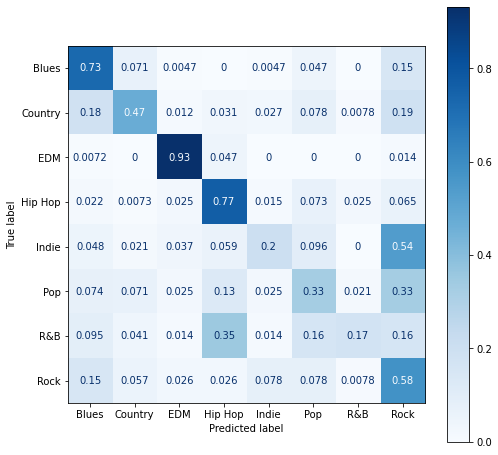

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels, pred_labels = evaluate_multiple_correct(trained_model_correct_labels, x_val, y_val)
fig, ax = plt.subplots(figsize=(8, 8))


cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')

### Try without pop genre

In [ ]:
# remove the pop genre to see if performance is better
df_no_pop = df_sampled[df_sampled['primary_genre']!= 'Pop']

x_train_no_pop, x_test_no_pop, y_train_no_pop, y_test_no_pop = train_test_split(df_no_pop['lyrics'], df_no_pop[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
x_val_no_pop, x_test_no_pop, y_val_no_pop, y_test_no_pop = train_test_split(x_test_no_pop, y_test_no_pop, test_size=0.5, random_state = 200)

In [ ]:
EPOCHS = 3
model_multiple_correct_labels_no_pop = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5

trained_model_correct_labels_no_pop, tr_loss_no_pop, tr_acc_no_pop, v_loss_no_pop, v_acc_no_pop = train_multiple_correct_labels(
    model_multiple_correct_labels_no_pop, x_train_no_pop, y_train_no_pop, x_val_no_pop, y_val_no_pop, LR, EPOCHS)


Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 4288/4288 [06:31<00:00, 10.96it/s]


Epochs: 1 | Train Loss:  0.741             | Train Accuracy:  0.555             | Val Loss:  0.679             | Val Accuracy:  0.594
starting


100%|██████████| 4288/4288 [06:30<00:00, 10.99it/s]


Epochs: 2 | Train Loss:  0.459             | Train Accuracy:  0.811             | Val Loss:  0.727             | Val Accuracy:  0.599
starting


100%|██████████| 4288/4288 [06:29<00:00, 11.00it/s]


Epochs: 3 | Train Loss:  0.338             | Train Accuracy:  0.958             | Val Loss:  0.693             | Val Accuracy:  0.653


Test Accuracy:  0.643


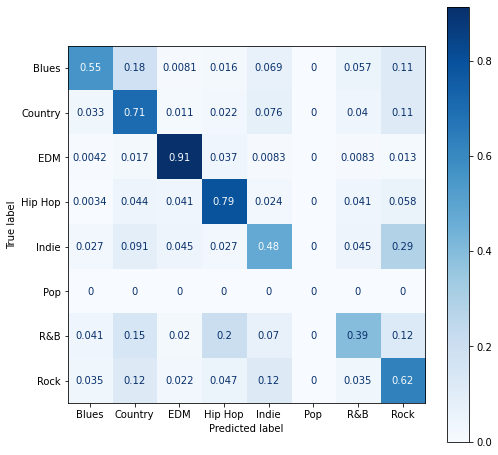

In [ ]:
true_labels, pred_labels = evaluate_multiple_correct(trained_model_correct_labels_no_pop, x_val_no_pop, y_val_no_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')

### Try without indie genre

In [ ]:
# remove the indie genre to see if performance is better
df_no_indie = df_sampled[df_sampled['primary_genre']!= 'Indie']

x_train_no_indie, x_test_no_indie, y_train_no_indie, y_test_no_indie = train_test_split(df_no_indie['lyrics'], df_no_indie[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
x_val_no_indie, x_test_no_indie, y_val_no_indie, y_test_no_indie = train_test_split(x_test_no_indie, y_test_no_indie, test_size=0.5, random_state = 200)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 4288/4288 [06:29<00:00, 11.00it/s]


Epochs: 1 | Train Loss:  0.727             | Train Accuracy:  0.555             | Val Loss:  0.652             | Val Accuracy:  0.634
starting


100%|██████████| 4288/4288 [06:30<00:00, 10.98it/s]


Epochs: 2 | Train Loss:  0.459             | Train Accuracy:  0.793             | Val Loss:  0.685             | Val Accuracy:  0.621
starting


100%|██████████| 4288/4288 [06:31<00:00, 10.95it/s]


Epochs: 3 | Train Loss:  0.322             | Train Accuracy:  0.960             | Val Loss:  0.677             | Val Accuracy:  0.647
Test Accuracy:  0.641


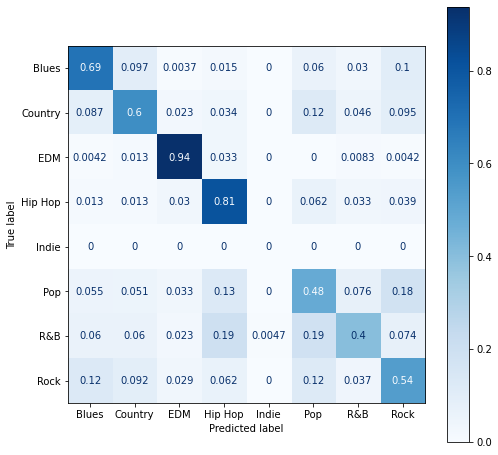

In [ ]:
EPOCHS = 3
model_multiple_correct_labels_no_indie = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5

trained_model_correct_labels_no_indie, tr_loss_no_indie, tr_acc_no_indie, v_loss_no_indie, v_acc_no_indie = train_multiple_correct_labels(
    model_multiple_correct_labels_no_indie, x_train_no_indie, y_train_no_indie, x_val_no_indie, y_val_no_indie, LR, EPOCHS)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model_correct_labels_no_indie, x_val_no_indie, y_val_no_indie)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


In [ ]:
torch.save(trained_model_correct_labels_no_indie.state_dict(), "gpt2-text-classifier-model-no-indie.pt")

In [ ]:
!zip gpt2-text-classifier-model-no-indie.pt.zip gpt2-text-classifier-model-no-indie.pt 

  adding: gpt2-text-classifier-model-no-indie.pt (deflated 8%)


### Try without indie and pop genres

In [ ]:
# remove the pop and indie genres to see if performance is better
df_no_indie_pop = df_sampled[~df_sampled['primary_genre'].isin(['Indie', 'Pop']) & ~df_sampled['secondary_genre'].isin(['Indie', 'Pop'])]

x_train_no_indie_pop, x_test_no_indie_pop, y_train_no_indie_pop, y_test_no_indie_pop = train_test_split(df_no_indie_pop['lyrics'], df_no_indie_pop[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
x_val_no_indie_pop, x_test_no_indie_pop, y_val_no_indie_pop, y_test_no_indie_pop = train_test_split(x_test_no_indie_pop, y_test_no_indie_pop, test_size=0.5, random_state = 200)

# x_train_no_indie, x_test_no_indie, y_train_no_indie, y_test_no_indie = train_test_split(df_no_indie['lyrics'], df_no_indie[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
# x_val_no_indie, x_test_no_indie, y_val_no_indie, y_test_no_indie = train_test_split(x_test_no_indie, y_test_no_indie, test_size=0.5, random_state = 200)

In [ ]:
df_no_indie_pop['primary_genre'].value_counts()

Blues      1750
EDM        1750
Country    1638
Hip Hop    1636
Rock       1570
R&B        1421
Name: primary_genre, dtype: int64

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda
using cuda
starting


100%|██████████| 3418/3418 [05:10<00:00, 11.00it/s]


Epochs: 1 | Train Loss:  0.595             | Train Accuracy:  0.613             | Val Loss:  0.499             | Val Accuracy:  0.698
starting


100%|██████████| 3418/3418 [05:10<00:00, 11.02it/s]


Epochs: 2 | Train Loss:  0.327             | Train Accuracy:  0.859             | Val Loss:  0.569             | Val Accuracy:  0.689
starting


100%|██████████| 3418/3418 [05:09<00:00, 11.03it/s]


Epochs: 3 | Train Loss:  0.229             | Train Accuracy:  0.970             | Val Loss:  0.500             | Val Accuracy:  0.728
Test Accuracy:  0.726


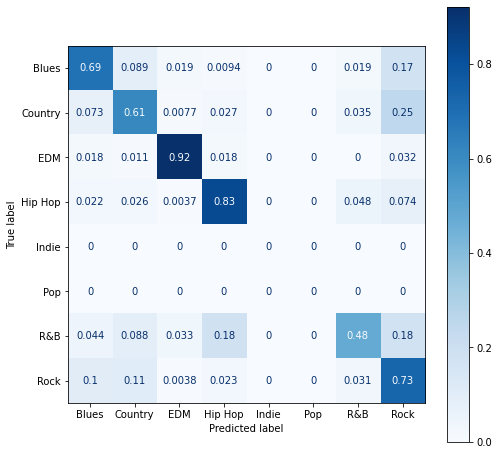

In [ ]:
EPOCHS = 3
model_multiple_correct_labels_no_indie_pop = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5

trained_model_correct_labels_no_indie_pop, tr_loss_no_indie_pop, tr_acc_no_indie_pop, v_loss_no_indie_pop, v_acc_no_indie = train_multiple_correct_labels(
    model_multiple_correct_labels_no_indie_pop, x_train_no_indie_pop, y_train_no_indie_pop, x_val_no_indie_pop, y_val_no_indie_pop, LR, EPOCHS)

# show confusion matrix
true_labels, pred_labels = evaluate_multiple_correct(trained_model_correct_labels_no_indie_pop, x_val_no_indie_pop, y_val_no_indie_pop)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')


In [ ]:
torch.save(trained_model_correct_labels_no_indie.state_dict(), "gpt2-text-classifier-model-no-pop-or-indie.pt")

In [ ]:
!zip gpt2-text-classifier-model-no-pop-or-indie.pt.zip gpt2-text-classifier-model-no-pop-or-indie.pt 

  adding: gpt2-text-classifier-model-no-pop-or-indie.pt (deflated 8%)


In [ ]:
from google.colab import files
files.download('gpt2-text-classifier-model-no-pop-or-indie.pt.zip')

# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Models

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

def show_plot(train_loss, val_loss, train_acc, val_acc):
  # if torch.cuda.is_available():
  #   train_acc = [acc.cpu() for acc in train_acc]
  #   val_acc = [acc.cpu() for acc in val_acc]
  
  x_range = range(1,len(train_loss)+1)
  plt.plot(x_range,train_loss)
  plt.plot(x_range,val_loss)
  plt.xlabel('Num epochs')
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss')
  plt.show()

  plt.plot(x_range,train_acc)
  plt.plot(x_range,val_acc)
  plt.xlabel('Num epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Training', 'Validation'])
  plt.title('Accuracy')
  plt.show()

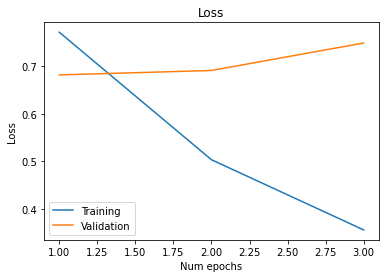

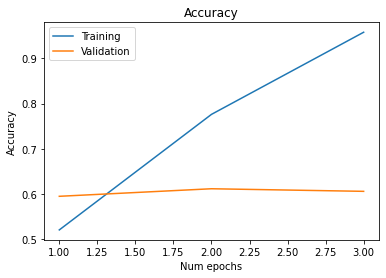

In [ ]:
show_plot(tr_loss, v_loss, tr_acc, v_acc)

In [ ]:
torch.save(model.state_dict(), "gpt2-text-classifier-model.pt")

Test Accuracy:  0.610


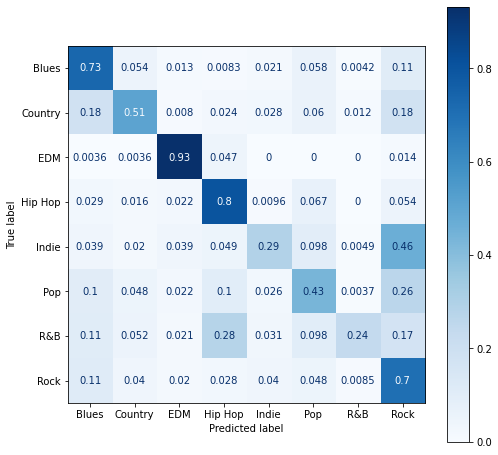

In [ ]:
true_labels, pred_labels = evaluate_multiple_correct(trained_model_correct_labels, x_val, y_val)
fig, ax = plt.subplots(figsize=(8, 8))


cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')

Plot confusion matrix

Test Accuracy:  0.545


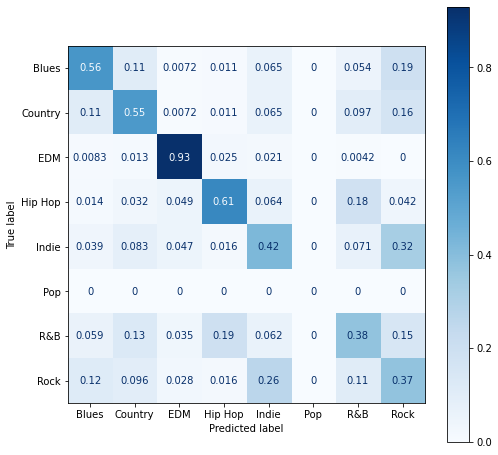

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels, pred_labels = evaluate(model2, x_val, y_val)
fig, ax = plt.subplots(figsize=(8, 8))


cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')

In [ ]:
# count parameters
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model2)

+-----------------------------+------------+
|           Modules           | Parameters |
+-----------------------------+------------+
|       gpt2.wte.weight       |  38597376  |
|       gpt2.wpe.weight       |   786432   |
|     gpt2.h.0.ln_1.weight    |    768     |
|      gpt2.h.0.ln_1.bias     |    768     |
| gpt2.h.0.attn.c_attn.weight |  1769472   |
|  gpt2.h.0.attn.c_attn.bias  |    2304    |
| gpt2.h.0.attn.c_proj.weight |   589824   |
|  gpt2.h.0.attn.c_proj.bias  |    768     |
|     gpt2.h.0.ln_2.weight    |    768     |
|      gpt2.h.0.ln_2.bias     |    768     |
|   gpt2.h.0.mlp.c_fc.weight  |  2359296   |
|    gpt2.h.0.mlp.c_fc.bias   |    3072    |
|  gpt2.h.0.mlp.c_proj.weight |  2359296   |
|   gpt2.h.0.mlp.c_proj.bias  |    768     |
|     gpt2.h.1.ln_1.weight    |    768     |
|      gpt2.h.1.ln_1.bias     |    768     |
| gpt2.h.1.attn.c_attn.weight |  1769472   |
|  gpt2.h.1.attn.c_attn.bias  |    2304    |
| gpt2.h.1.attn.c_proj.weight |   589824   |
|  gpt2.h.

82699016